# Введение в глубокое обучение
## Занятие 8. Языковое моделирование


##### Авторы:
[Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

Горохов Олег

## План занятия

1. Задача языкового моделирования.
2. Построение рекуррентной нейронной сети для задачи языкового моделирования.
3. Генерация текста с помощью рекуррентной нейронной сети.
4. Дополнительные особенности языковых моделей.

## 1. Задача языкового моделирования.

Мы можем создать нейронную сеть, которая сможет генерировать текст, похожий на тексты из обучающей выборки.

Для этого прибегаем к задаче **языкового моделирования**.

В рамках этой задачи мы пытаемся предсказать новый токен (символ, слово и т.д.) на основании **контекста**, т.е. токенов, которые нам уже известны.

Самый простой пример задачи языкового моделирования - это задача **прямого языкового моделирования**, когда мы пытаемся предсказать следующий токен на основании известных предыдущих токенов.

На самом деле вы все уже встречались с этой задачей в жизни:

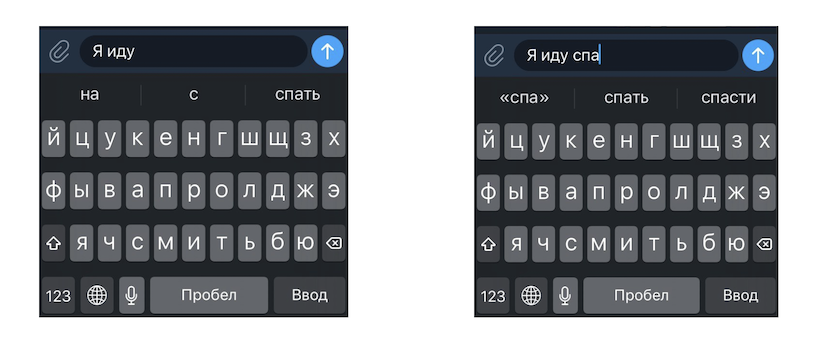

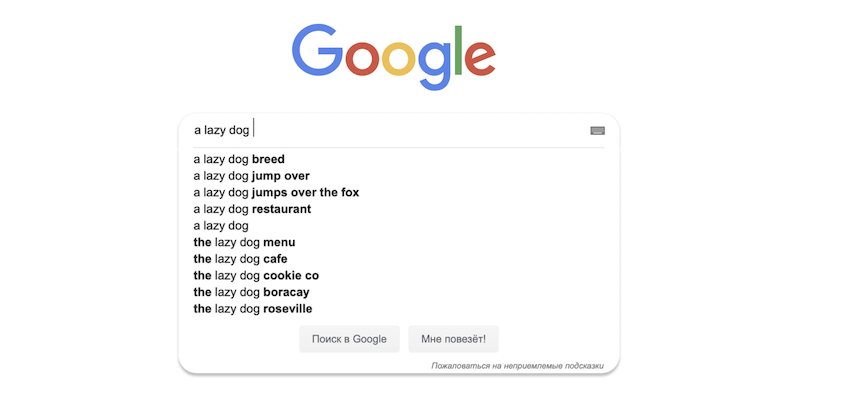

Более формально, прямая языковая модель предсказывает **вероятность** встретить определённый токен (или группы токенов) после заданной последовательности токенов:

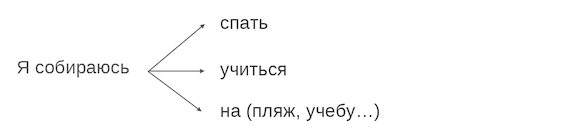

Таким образом, прямая языковая модель (LM) должна быть устроена примерно так:

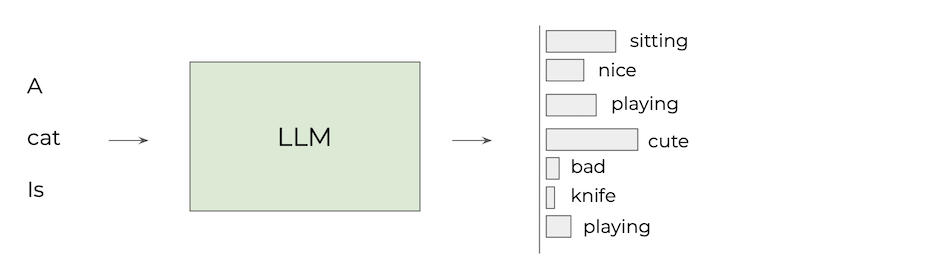

Если LM тут — обучаемая нейросеть, то становится понятно, как такую нейросеть обучать:
- задача — задача классификации на $n$ классов, где $n$ — размер словаря;
- данные — набор текстов;
- идем по тексту с начала до конца, в каждый момент времени по текущему преффиксу (A cat is) учим LM предсказывать следующее слово. Правильное слово — то, которое в нашем тексте идет следующим (sitting). Учим на cross-entropy между выданным распределением вероятности и правильным ответом (one-hot вектором слова sitting).

### Формальная постановка задачи

***Дано:***

1. Словарь токенов (конечное множество) $\mathbb{V}={}: |\mathbb{V}|=N$.
2. Конечная последовательность токенов (текст)
$$w_0, w_1,..., w_{t-1}: \forall i=1,...,t-1 \Rightarrow w_i \in \mathbb{V}$$

***Нужно:***

Построить модель, которая позволяет оценить вероятность употребления каждого токена из словаря на основании известной последовательности $w_0, w_1,..., w_{t-1}$. Т.е. нужно оценить распределение вероятностей, построив вектор $P=(P_1,...,P_N)$:

$$\forall w_t^i \in \mathbb{V} \Rightarrow P_i=P_{\Theta}(w_t^i|w_{t-1},...,w_0)$$


### Вероятность текста. Перплексия.

А теперь поговорим о том, как оценивать качества языкового моделирования.

Поскольку языковая модель позволяет оценивать вероятности следующего токена при условии предыдущих, мы можем посчитать вероятность конкретного текста - последовательности токенов $w_0,...,w_t$:

$$P(w_0, w_1,...,w_t) = ∏_{i=0}^{t}{P(w_i|w_{i-1},...,w_0)}$$

На практике удобнее считать не произведение вероятностей, а его логарифм. Потому что вероятность - это небольшое число. И если мы будем считать произведение, то можем получить очень маленькое число, которое будет вычислено неточно (из-за ошибок округления). Поэтому, лучше считать **логарифм** от этого произведения:

$$log[P(w_0, w_1,...,w_t)] = log[∏_{i=0}^{t}{P(w_i|w_{i-1},...,w_0)}] = \sum_{i=0}^t{log[P(w_i|w_{i-1},...,w_0)]}$$

В последнем равенстве мы использовали свойство логарифма произведения (он раскладывается в сумму логарифмов).

Тогда мы можем использовать значение вероятности текста для оценки качества нашей модели. Для этого используется так называемая **перплексия**, которая вычисляется по формуле:

$$PP(w_0,...,w_t) = e^{-\frac{1}{t}*log[P(w_0, w_1,...,w_t)]}$$

Здесь мы используем экспоненту для обратного преобразования логарифма в вероятность, а коэффициент $\frac{1}{t}$ используется для нормализации (чтобы размер текста не влиял на итоговый результат).

Таким образом, мы можем построить и обучить некоторую языковую модель на обучающей выборке. А далее применить ее к новому тексту из тестовой выборки и оценить вероятность каждого последующего токена в этом новом тексте на основе нашей обученной языковой модели. Чем ближе предсказанный нашей моделью текст к реальному, тем более качественной является модель.

При этом, чем ниже перплексия, тем лучше. Подумайте самостоятельно, почему так происходит.

### Применение рекуррентных сетей в задаче языкового моделирования

Для задачи языкового моделирования очень хорошо подходят рекуррентные нейронные сети, рассмотренные на прошлом занятии. Далее разберём конкретный пример построения рекуррентной нейронной сети для решения задачи прямого языкового моделирования.

## 2. Построение рекуррентной нейронной сети для задачи языкового моделирования.


Напомним, что рекуррентную нейронную сеть можно рассматривать как последовательное применение плотного слоя к входу $x_t$ и предыдущему состоянию `rnn` $h_t$:

<img src="https://raw.githubusercontent.com/neychev/small_DL_repo/master/rnn.png" width=480>

Тогда, эту архитектуру можно применить для задачи языкового моделирования следующим образом:

1. Возьмём большой корпус текста, который разобьем на последовательности токенов $x_0, x_1,...,x_k$.
2. Подаём на вход RNN полученные последовательности. Расчитываем вероятностное распределение следующих токенов $\hat{y_0},...,\hat{y_k}$.
3. Вычисляем лосс-функцию - кросс-энтропию между предсказанием и истинным значением следующего токена $y_0,...,y_k$. Здесь каждый $y_i$ - это One-Hot вектор для следующего слова в последовательности $x_i$.
4. Оптимизируем градиентным спуском.

Для демонстрации указанного алгоритма перейдём в [презентацию](https://docs.google.com/presentation/d/1z60oWllZUvPkMnjDQQ6PPRI-ri8P6KYqPUopXJY9RGM/edit?usp=sharing).

## 3. Генерация текста с помощью рекуррентной нейронной сети.



Если у нас есть обученная языковая модель, которая умеет оценивать вероятность следующего токена в тексте, то с помощью этой модели становится возможно генерировать новый текст.

Алгоритм тут будет такой:
- подаем на вход LLM начало предложения (A cat is),
- получаем из LLM распределение вероятностей на следующее слово из словря,
- выбираем на основе распределения вероятностей следующее слово в тексте (A cat is sitting),
- подаем новое начало предложения на вход LLM (A cat is sitting),
- ...

Теперь попробуем разобрать этот алгоритм на конкретном примере.

Рассмотрим набор данных, который представляет собой список имен. Каждая последовательность – отдельное имя. В качестве токенов будем рассматривать отдельные символы (буквы). То есть, мы будем учить RNN генерировать имена =)

In [ ]:
import os                                                                         # импортируем часть библиотеки для взаимодействия с данными на
                                                                                  # компьютере и для доступа к окружению, где запущен notebook
from random import sample                                                         # random - часть библиотеки, которая отвечает за случайные числа

import numpy as np                                                                # библиотека для работы с векторами и матрицами

import torch                                                                      # тут все нейронные сети
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F                                                   # функции, которые нам пригодятся

import matplotlib.pyplot as plt                                                   # для построения графиков
from IPython.display import clear_output                                          # для интерактивного построения графиков
                                                                                  # clear_output позволяет покадрово рисовать график сходимости

In [ ]:
embed = nn.Embedding(10, 4)                                                       # 10 - число эмбеддингов, 4 - их размерность

Загрузим и предобработаем данные:

In [ ]:
! wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/names.txt -O names.txt  # скачиваем names.txt

--2024-03-27 14:42:31--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]  54.56K  --.-KB/s    in 0.007s  

2024-03-27 14:42:31 (7.70 MB/s) - ‘names.txt’ saved [55868/55868]



In [ ]:
start_token = " "                                                                 # технический токен (здесь это пробел), с которого начинается
                                                                                  # каждая последовательность

with open("names.txt") as f:                                                      # открыли файл
    names = f.read()[:-1].split('\n')                                             # names - все, что есть, разделенное по переносу строки
    names = [start_token + line for line in names]                                # к каждому элементу последовательности добавили пробел в начало

In [ ]:
names[:10]                                                                        # выводим первые 10 имён из набора данных

[' Abagael',
 ' Abagail',
 ' Abbe',
 ' Abbey',
 ' Abbi',
 ' Abbie',
 ' Abby',
 ' Abigael',
 ' Abigail',
 ' Abigale']

In [ ]:
len(names)

7944

Как видим, в датасете 7944 примера. Обратите внимание, каждая последовательность начинается с пробела (технический токен, который позволит сети понять, что именно с пробела начинается имя; для упрощения в данной задаче считаем, что пробел встречается **только** в начале каждого имени, больше пробелов в данных нет).

Рассмотрим распределение длин последовательностей:

max_length = 16


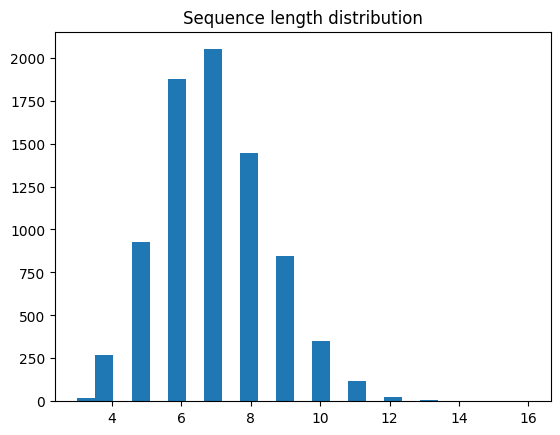

In [ ]:
MAX_LENGTH = max(map(len, names))                                                 # map применяет конкретную функцию к списку или любому итерируемогу объекту
                                                                                  # в данном случае происходит подсчет длины каждого элемента множества names
                                                                                  # и поиск максимума от результата
print("max_length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);                                          # hist - гистограмма
                                                                                  # считаем количество вхождений именно для списка

### Предобработка текста

Первый этап решения любой задачи - предобработка.

Для начала построим "словарь" из всех уникальных токенов и пронумеруем их. Тогда мы можем кодировать входные данные как последовательность их индексов символов. Например, имя "Aboba" будет представлено как `[0, 1, 15, 1, 0]`.

Для начала можно построить множество всех уникальных токенов (букв) в словаре. Для этого воспользуемся типом `set`:

In [ ]:
set('aaaaaabbbbcc')                                                               # вывод всех уникальных элементов-символов в строке

{'a', 'b', 'c'}

In [ ]:
tokens = set()                                                                    # множество всех уникальных токенов (символов) в наборе данных

for name in names:                                                                # итерируемся по всем именам
    tokens.update(set(name))                                                      # считаем set от последовательности и обновляем множество,
                                                                                  # добавляя в него все уникальные новые токены из нового имени
tokens = list(tokens)                                                             # оборачиваем все в список

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  55


Видим, что в данном датасете присутствует 55 уникальных токенов. Если мы внимательно посмотрим на датасет, то увидим, что в именах присутствуют строчные и заглавные буквы латинского алфавита (26+26=52 токена), технический символ (пробел), а также ряд специальных символов (апостроф и дефис). Итого получается 55 токенов.

Теперь создадим словарь токенов, где ключём будет токен, а значением - уникальный индекс соответствующего токена:

In [ ]:
# <словарь символ -> его id (index in tokens list)>
token_to_id = {
    token: idx for idx, token in enumerate(tokens)                                # пронумеровали все токены, каждому токену соответствует его
}                                                                                 # порядковый номер

In [ ]:
token_to_id

{'G': 0,
 'v': 1,
 'o': 2,
 't': 3,
 'W': 4,
 'd': 5,
 '-': 6,
 'u': 7,
 'Q': 8,
 'e': 9,
 's': 10,
 'U': 11,
 'H': 12,
 'm': 13,
 'w': 14,
 'B': 15,
 'P': 16,
 'N': 17,
 'D': 18,
 'C': 19,
 'M': 20,
 'E': 21,
 'A': 22,
 'i': 23,
 'n': 24,
 'c': 25,
 'y': 26,
 'z': 27,
 'I': 28,
 'b': 29,
 'a': 30,
 'J': 31,
 'x': 32,
 "'": 33,
 'Y': 34,
 'g': 35,
 'h': 36,
 'f': 37,
 'k': 38,
 'R': 39,
 ' ': 40,
 'l': 41,
 'q': 42,
 'O': 43,
 'Z': 44,
 'j': 45,
 'S': 46,
 'L': 47,
 'K': 48,
 'V': 49,
 'p': 50,
 'r': 51,
 'X': 52,
 'T': 53,
 'F': 54}

Теперь каждому токену соответствует уникальный индекс.

Наконец, реализуем функцию для преобразования список имен в матричное представление, которое в дальнейшем будет использоваться в качестве батча.
Т.к. тексты могут быть различной длины, а нейронные сети работают с данными фиксированной длины, дополним их до максимальной длины `max_len` или до длины самого длинного имени из выборки, если этот параметр не указан:

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' ']):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))                                     # считаем макс длину среди всех имеющихся имен и используем ее
                                                                                  # или макс длину, заданную извне (если такая есть)
    names_ix = np.zeros([len(names), max_len], dtype='int32') + pad                       # матрица размером [количество имен х макс длина] из нулей
                                                                                  # затем заменяем нули на индекс падтокена
                                                                                  # pad - технический токен (в данном случае – пробел), который приводит
                                                                                  # последовательности к одинаковой длине

    for i in range(len(names)):                                                   # итерируемся по всем именам
        line_ix = [token_to_id[c] for c in names[i]]                              # и для каждого элемента имени переводим токен (символ)
                                                                                  # в соответствующий индекс
        names_ix[i, :len(line_ix)] = line_ix                                      # записываем в матрицу новую строку из индексов

    return names_ix

Рассмотрим пример.

Выведем каждое тысячное имя из датасета (это и будет батч), а затем для каждого из этого имени выведем его векторное представление, где вместо каждого токена укажем его индекс в словаре:

In [ ]:
print('\n'.join(names[::1000]))
print(to_matrix(names[::1000], max_len=MAX_LENGTH))

 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy
[[40 22 29 30 35 30  9 41 40 40 40 40 40 40 40 40]
 [40 19 41 30 51  9 10  3 30 40 40 40 40 40 40 40]
 [40  0 41  2 51 26 40 40 40 40 40 40 40 40 40 40]
 [40 47 23 41 23 30 24  9 40 40 40 40 40 40 40 40]
 [40 16 51 23 10 10 23  9 40 40 40 40 40 40 40 40]
 [40  0  9  9  3 30 40 40 40 40 40 40 40 40 40 40]
 [40  0 23  2  1 30 24 24  9 40 40 40 40 40 40 40]
 [40 16 23 35 35 26 40 40 40 40 40 40 40 40 40 40]]


Подсветим все позиции, которые соответствуют пробелам. Для этого используем специальный вид графика pcolormesh, который позволяет визуализировать матрицу цветами. Жёлтый цвет будет обозначать пробел, а фиолетовый - непробельный символ:

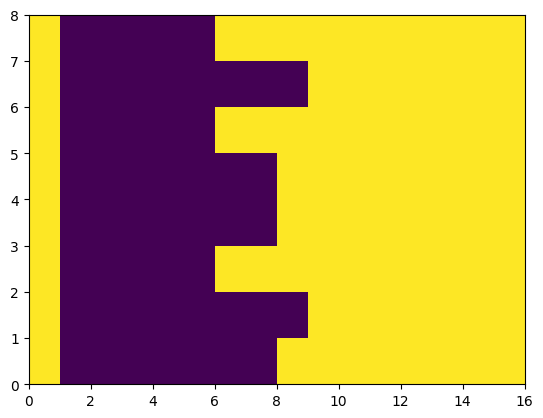

In [ ]:
plt.pcolormesh(to_matrix(names[::1000], max_len=MAX_LENGTH)==token_to_id[' '])

Теперь давайте напишем класс `CharRNNLoop`, который позволяет предсказывать следующий токен на основании предыдущих:

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()

Наконец, проверим, что все работает. В качестве батча при этом выберем подвыборку размера 32 из исходного набора данных:

In [ ]:
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logits = model(batch_ix)

In [ ]:
logits.shape

torch.Size([32, 16, 55])

Т.к. задача предсказания следующего токена – это задача классификации, в качестве функции потерь будет выступать уже знакомая нам кросс-энтропия.

В качестве "истинных значений" мы будем использовать `batch_ix[:, 1:]` - матрицу из индексов токенов, сдвинутых на один шаг вперед.

batch_ix = _Abigail

logits = Abigail_

batch_ix[1:] logits[:-1]

In [ ]:
predictions_logp = F.log_softmax(logits[:, :-1], dim=-1)                          # все кроме последнего предсказания, т.к. в конце последовательности нам не нужно ничего предсказывать
actual_next_tokens = batch_ix[:, 1:]                                              # наши правильные ответы (все что есть, начиная с 1 шага), исключаем первый шаг, т.к. в начале мы находились в нулевом состоянии и ничего не предсказывали

loss = criterion(                                                                 # считаем функцию ошибки от предсказаний и истинных значений
    predictions_logp.contiguous().view(-1, num_tokens),                           # вытягиваем все в один батч (т.е. из размерности (batch, time, prob) переходим к (batch*time, prob))
    actual_next_tokens.contiguous().view(-1)
)

loss.backward()

### Обучение модели

Следующий шаг - обучить нашу модель на задачу классификации.

Сама процедура обучения практически не отличается от предыдущих. Единственное различие заключается в том, что в этот раз мы семплируем строки переменной длины, а затем приводим их к единой длине внутри одного батча:

In [ ]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()                                                          # используем оптимизатор Adam

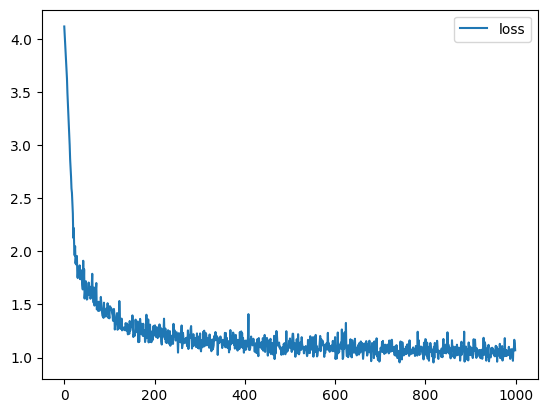

In [ ]:
%time

MAX_LENGTH = 16
history = []

for i in range(1000):                                                             # всего 1000 итераций

    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)                   # выбрали 32 случайных элемента из всех имен
    batch_ix = torch.LongTensor(batch_ix)                                         # преобразовали в тензор

    logits = model(batch_ix)                                                    # получили последовательность logp

    # Считаем loss
    predictions_logp = F.log_softmax(logits[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Обучение методов backprop
    loss.backward()                                                               # посчитали градиенты
    opt.step()
    opt.zero_grad()                                                                  # сделали шаг

    # код отрисовки графика
    history.append(loss.item())
    if (i+1)%100==0:                                                              # на каждом сотом шаге обновляем график
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."     # проверяем, что среднее значение за последние 10 шагов больше
                                                                                  # среднего значения за первые 10 шагов (если нет – модель не сошлась)

### Генерация имён

После обучения языковой модели (а обученная нейросеть является языковой моделью) перейдем к генерации данных. Для этого воспользуемся функцией ниже:

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]                    # преобразуем seed_phrase в последовательность индексов токенов
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits = model(x_sequence)                                                # новое скрытое состояние и логит для след токена - это
                                                                                  # последний элемент последовательности и текущее скрытое состояние
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][-1]      # считаем вероятность: softmax от текущих логитов
                                                                                  # temperature отвечает за случайность (гиперпараметр)

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)                           # из всех токенов с распределением p_next
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)                      # добавляем к последовательности

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])             # возвращаем все, сконкатенировав через пустую строку

Рассмотрим несколько случайных примеров:

In [ ]:
for _ in range(10):
    print(generate_sample(model, temperature=1.))

 Greem          
 YayTue         
 AAng           
 Sizguranda     
 GHareMen       
 Vasty          
 Mormy          
 Hergiv         
 Dara           
 Alyrota        


In [ ]:
for _ in range(10):
    print(generate_sample(model, temperature=.001))

 Marile         
 Marile         
 Marile         
 Marile         
 Marile         
 Marile         
 Marile         
 Marile         
 Marile         
 Marile         


In [ ]:
for _ in range(10):
    print(generate_sample(model, temperature=1000))

 avPwxTjOyTvlsSj
 zrYjNBF-dNusYnN
 UPtXMqdSClRJGfR
 swxF-vUACn-JFrX
 Q'cvuuaSOwFGQvi
 ExTtHomaBAQMPSq
 vWNYUIpNKPIRoXZ
 GzuifOJaJjhqi'q
 FQfhIpofboyVwyJ
 zRRCHWMgIbvElH'


Также мы можем задать некоторую подстроку для инициализации начального состояния нашей модели:

In [ ]:
for _ in range(50):
    print(generate_sample(model, seed_phrase=' Ale', temperature=1.))

 Aleetthe       
 Aleplli        
 Alerue         
 Alenla         
 Alerie         
 Alelitandho    
 Alerie         
 Alerilo        
 Alei           
 Alerbe         
 Alele          
 Alec           
 Alenlen        
 Aletth         
 Alerie         
 Alemen         
 Alemen         
 Aleigenn       
 Alesay         
 Aleleda        
 Aleyret        
 Aleriph        
 Alelet         
 Alenan         
 Alegin         
 Alerkia        
 Aleyinn        
 Alere          
 Alenfyn        
 Aleszy         
 Aleat'         
 Alery          
 Alericka       
 Alearni        
 Aleni          
 Aletha         
 Alerahby       
 Ale            
 Alerh          
 Alettelse      
 Aleston        
 Alere          
 Aleallane      
 Aleria         
 Alenan         
 Aleneu         
 Aleie          
 Aletettorsy    
 Alerirtta      
 Aley tan       


## 4. Дополнительные возможности языковых моделей.

### Температура

В примере выше мы использовали функцию `generate_sample` для генерации имён. В этой функции используется магический параметр, который мы назвали **температурой** (temperature). Температуру можно воспринимать как **гиперпараметр**, который отвечает за некоторую случайность. Она позволяет увеличивать энтропию (т.е. разброс данных) при формировании вероятностей из логитов. Чем выше это значения, тем ближе к нулю будут значения итоговых вероятностей. Например, если мы получим значения логитов `[1, 2, 3]`, а значение температуры равно 1000, то в результате мы преобразуем логиты (поделим на температуру) к формату $[1e^{-3}, 2e^{-3}, 3e^{-3}]$. Разница между этими значениями не сильно велика. Далее, применим функцию Softmax (экспоненту), мы получим примерно одинаковые значения вероятностей. Если наоборот, мы возьмём маленькое значение температуры, даже для очень похожих значений, мы получим большую разницу в итоговых вероятностях.

Давайте посмотрим, как зависит итоговый результат от температуры:

In [ ]:
for _ in range(50):
    print(generate_sample(model, seed_phrase=' Serg', temperature=.1))

 Sergel         
 Sergel         
 Sergelle       
 Sergel         
 Sergel         
 Serge          
 Sergel         
 Sergel         
 Serger         
 Sergel         
 Sergel         
 Sergel         
 Serger         
 Sergel         
 Sergel         
 Sergin         
 Sergel         
 Sergel         
 Sergel         
 Sergel         
 Sergel         
 Sergin         
 Sergel         
 Sergella       
 Sergel         
 Sergel         
 Sergel         
 Serger         
 Sergel         
 Sergel         
 Sergel         
 Sergel         
 Serga          
 Sergel         
 Serger         
 Sergel         
 Sergelle       
 Sergel         
 Sergin         
 Sergel         
 Sergel         
 Sergel         
 Sergel         
 Sergel         
 Sergin         
 Sergan         
 Sergel         
 Sergel         
 Sergel         
 Sergel         


In [ ]:
for _ in range(50):
    print(generate_sample(model, seed_phrase=' Serg', temperature=10))

 Sergm FYyeUtsjJ
 SergW'UTm'vscxL
 SergFppqtFxNzld
 SergwnbEGq IREp
 SergGeaMaBbtOFb
 Sergje  nGjy F 
 SergMbalhAUhQvs
 SergamEeXGhdsYZ
 SergZNdkoRQZXJt
 SergazaOFqdghWj
 SergUbMfJlORoHO
 SergeDjqgurcXVy
 SergCesgTIWhPTy
 Sergf paycttyvr
 SergByQxDxXFZIv
 Serg'ID-ZdkcZ-m
 SergYgzCpMMUHES
 SergBi-byYDAE-R
 SergRzLQhtXurBx
 SergOFtha CfRCm
 SergvdThebrKexr
 SergsXDxxEaX po
 SergNlsbhCBzcwr
 SergXtkWAIRrtkp
 SergFWnclseLkFZ
 Serg'mvofIpOLTQ
 SergQsqZ'h-tVXX
 SergfvFeeRPaKRg
 SergSyxzoslMzwd
 SergWoHichuZrUg
 SergN-lVsaaMn x
 SergihUCvpkQER'
 SergkocZqvrNUlO
 SergBdpGpkhCoFg
 SergfhSWTptZtlr
 SergsLQlDJpPIGb
 SergftNpl Utcjb
 SergsDBdqSs-LU-
 SergycGTiniIAKU
 SergcbxvsObxev'
 Serg'ZlfYyjknIz
 SergeVdByoP-Yl'
 SergPsnDSNcMild
 SergwddTlbLArBo
 SergWpoJDxOXiwt
 Serg-'HvIydaTOn
 SergjGzLL'aUIXh
 SergRlURprEXCfh
 SergCqiTyrXGZEd
 SergEAnuc'G-eck


Видим, что при маленьких значениях температуры генерируются имена, в целом похожие на реальные. Но при этом, генерируются примерно одинаковые токены, т.к. вероятности у них получаются примерно одинаковыми. В то время как большие значения температуры увеличивают разброс между вероятностями, что приводит к генерации "мусора". Поэтому, подбор этого гиперпараметра очень сильно влияет на итоговый результат.

Дома можете попрактиковаться с разными значениями температуры и подумать, какое значение в данной задаче является оптимальным и почему так происходит.

### Аномалии

Ещё одна проблема, с которой мы сталкиваемся при решении задач языкового моделирования, заключается в том, что классические рекуррентные нейронные сети очень неустойчивы к выбросам в исходных данных. Это связано с понятием "забывания" старой информации.

Т.е. мы можем попробовать предсказать имя для входной последовательности, которая заканчивается неким "мусором":

In [ ]:
for _ in range(50):
    print(generate_sample(model, seed_phrase=' SergAAA', temperature=1.))

 SergAAAsh      
 SergAAAna      
 SergAAAnde     
 SergAAA        
 SergAAAta      
 SergAAAltina   
 SergAAAme      
 SergAAAnn      
 SergAAA        
 SergAAAe       
 SergAAA        
 SergAAAnc      
 SergAAAna      
 SergAAAnk      
 SergAAAna      
 SergAAAnca     
 SergAAAnbe     
 SergAAAle      
 SergAAAnre     
 SergAAAl       
 SergAAAd       
 SergAAAlla     
 SergAAAn       
 SergAAAnt      
 SergAAAd       
 SergAAAbe      
 SergAAAn       
 SergAAAna      
 SergAAAl       
 SergAAA        
 SergAAAl       
 SergAAAnt      
 SergAAAndr     
 SergAAAng      
 SergAAAlld     
 SergAAArrl     
 SergAAAllie    
 SergAAAn       
 SergAAAnna     
 SergAAAk       
 SergAAAle      
 SergAAAlde     
 SergAAAes      
 SergAAAl       
 SergAAAnra     
 SergAAAmlite   
 SergAAAthe     
 SergAAAgba     
 SergAAAb       
 SergAAAm       


Видим, что наша модель начинает также генерировать некоторый мусор. Это связано с тем, что RNN "забывает" предыдущие символы, обращая внимание на то, что идет в конце. В конце текста мы указали несколько символов А, и сеть "забывает" символы, идущие ранее, пытаясь предсказать, какой символ будет дальше, думая, что дальше тоже будут символы А, а потом она пытается сгенерировать какие-то случайные символы.

Эту проблему можно попробовать решить с помощью более мощных архитектур нейронных сетей, например LSTM, о которых мы говорили на прошлом занятии:

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=3)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [ ]:
model_lstm = CharLSTMLoop()
opt_lstm = torch.optim.Adam(model_lstm.parameters())
criterion_lstm = nn.NLLLoss()

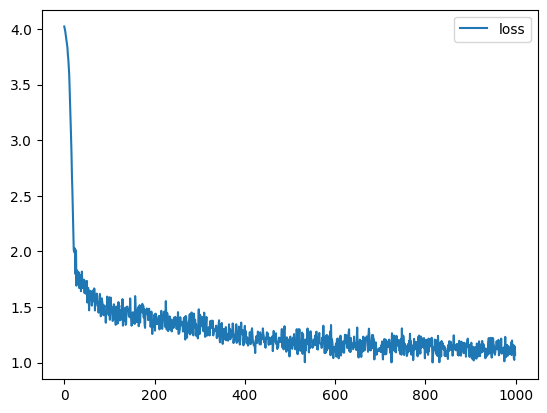

In [ ]:
MAX_LENGTH = 16
history = []

for i in range(1000):                                                             # всего 1000 итераций

    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)                   # выбрали 32 случайных элемента из всех имен
    batch_ix = torch.LongTensor(batch_ix)                                         # преобразовали в тензор

    logits_lstm = model_lstm(batch_ix)                                            # получили последовательность logp

    # Считаем loss
    predictions_logp_lstm = F.log_softmax(logits_lstm[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss_lstm = criterion_lstm(
        predictions_logp_lstm.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Обучение методов backprop
    loss_lstm.backward()                                                               # посчитали градиенты
    opt_lstm.step()
    opt_lstm.zero_grad()                                                                  # сделали шаг

    # код отрисовки графика
    history.append(loss_lstm.item())
    if (i+1)%100==0:                                                              # на каждом сотом шаге обновляем график
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."     # проверяем, что среднее значение за последние 10 шагов больше
                                                                                  # среднего значения за первые 10 шагов (если нет – модель не сошлась)

In [ ]:
for _ in range(50):
    print(generate_sample(model_lstm, seed_phrase=' SergAAA', temperature=1.))

 SergAAAen      
 SergAAA        
 SergAAAarey    
 SergAAAe       
 SergAAAan      
 SergAAAoi      
 SergAAAaek     
 SergAAAe       
 SergAAAapcete  
 SergAAAete     
 SergAAAa       
 SergAAAe       
 SergAAAaa      
 SergAAA        
 SergAAAy       
 SergAAAaneldie 
 SergAAAie      
 SergAAA        
 SergAAAe       
 SergAAAer      
 SergAAAta      
 SergAAAoa      
 SergAAAjia     
 SergAAAa       
 SergAAAaton    
 SergAAAen      
 SergAAA        
 SergAAAya      
 SergAAAag      
 SergAAAta      
 SergAAAe       
 SergAAAa       
 SergAAAila     
 SergAAAnae     
 SergAAAaa      
 SergAAAesd     
 SergAAAan      
 SergAAAaria    
 SergAAA        
 SergAAAa       
 SergAAAa       
 SergAAAa       
 SergAAAyns     
 SergAAAao      
 SergAAAud      
 SergAAAela     
 SergAAAtial    
 SergAAAeop     
 SergAAAy       
 SergAAAen      


Видим, что эта модель уже не генерирует "мусор", как было раньше. Она встречает символы A на конце и понимает, что это некоторый мусор. И считает, что в данной ситуации нужно завершить генерацию имени. Можете дома попрактиковаться с параметром температура и с размерностями LSTM-слоев и посмотреть, как будет работать модель.

### BPE

Ещё один интересный подход, который можно использовать для улучшения качества сети - это кодирование n-грамм. Наиболее популярным является подход кодирования биграмм (byte pair encoding, BPE).

Он основан на идее кодирование не одного токена последовательности, а целых групп последовательности n подряд идущих токенов (n-грамм).

Рассмотрим пример кодирования биграмм.

Допустим, у нас есть последовательность токенов (символов):

`aaabdaaabac`

Мы видим, что в ней часто повторяются два подряд идущих токенов `a`. Тогда давайте произведём **замену** пары токенов `aa` на **новый токен**, назовём его `Z`:

```
ZabdZabac
Z=aa
```

Аналогично, можно повторить эту процедуру, заменив пару `ab` на новый токен `Y`:

```
ZYdZYac
Y=ab
Z=aa
```

Наконец, можем снова повторить эту процедуру уже для новых токенов, заменив пару `ZY` на новый токен `X`:


```
XdXac
X=ZY
Y=ab
Z=aa
```

Теперь мы видим, что размер последовательности уменьшился. Соответственно, сеть будет работать быстрее. И мы можем обучать и применять модель уже для новой последовательности токенов `XdXac` (соответственно, и для нового словаря, к которому будут добавлены токен `X`). Естественно, при генерации также будет генерироваться наш новый токен `X`. Соответственно, после генерации придётся осуществлять *обратное преобразование*, заменяя токен X по нашим правилам:

```
X=ZY
Y=ab
Z=aa
```

Как показывет практика, такой подход тоже является очень эффективным в современных моделях.

### Общая задача языкового моделирования

До этого мы говорили лишь про задачу **прямого** языкового моделирования, пытаясь предсказать последующий токен на основании предыдущих.

Но ничто не мешает нам предсказывать предыдущий токен на основании последующих. Это приводит к задаче **обратного языкового моделирования**. Она тоже применяется в ряде задач.

Также можно совместить два этих подхода и попробовать генерировать пропущенный токен в последовательности. Это приводит нас к задаче **маскированного языкового моделирования**. В этом случае мы заменяем один или несколько токенов на специальные технические токены (маски):

Мама <МАСКА> мыла раму.

И сначала пытаемся предсказать токен <МАСКА> на основании предыдущих токенов (Мама), а затем на основании последующих токенов (мыла раму). А затем объединить полученные распределения вероятностей и вынести итоговое решение о том, какой токен нужно вставить вместо маски. Этот подход используется в более современных моделях. Например, в BERT, о котором мы поговорим на следующем занятии.

## Дополнительно

- Лекции Deep Learning School по языковому моделированию:
    - старое:
        - [Языковое моделирование. Частотный подход](https://youtu.be/aS2A7b-4uT4?feature=shared);
        - [Языковое моделирование. Нейронные сети](https://youtu.be/-tK7WcE5Wfo?feature=shared);
    - новое:
        - [Языковое моделирование. Постановка задачи](https://youtu.be/DHuRg6iO6FU?feature=shared);
        - [Языковое моделирование. N-грамные модели](https://youtu.be/iszyO98wobw?feature=shared);
        - [Рекуррентные языковые модели](https://youtu.be/nyzJA3lUx1c?feature=shared);
        - [Генерация текста с помощью языковых моделей](https://youtu.be/iR7p5FCeE4M?feature=shared);
        - [Семинар. Языковое моделирование.](https://youtu.be/SzbdlJ0wBCo?feature=shared)